## 01-Classification (opened vs closed eye)

In [1]:
import os
from tensorflow.keras.utils import load_img, img_to_array, array_to_img, image_dataset_from_directory
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

import pandas as pd
from tensorflow.data import Dataset

from tensorflow import strings
from tensorflow.io import read_file, decode_image, decode_jpeg

from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Rescaling, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

You can find an example of data [here on kaggle](https://www.kaggle.com/datasets/tauilabdelilah/mrl-eye-dataset).

In order to use `image_dataset_from_directory`, ensure that you have to folders for the classification task as specified [here in tf documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory).

In [2]:
!ls ./src

close open


In [3]:
DATA_DIR = './src/'

In [4]:
os.listdir(DATA_DIR+'/open/train')

['openedEye416.jpg',
 'openedEye370.jpg',
 'openedEye364.jpg',
 'openedEye402.jpg',
 'openedEye358.jpg',
 'openedEye172.jpg',
 'openedEye83.jpg',
 'openedEye97.jpg',
 'openedEye166.jpg',
 'openedEye40.jpg',
 'openedEye54.jpg',
 'openedEye68.jpg',
 'openedEye199.jpg',
 'openedEye204.jpg',
 'openedEye210.jpg',
 'openedEye238.jpg',
 'openedEye239.jpg',
 'openedEye211.jpg',
 'openedEye205.jpg',
 'openedEye198.jpg',
 'openedEye69.jpg',
 'openedEye55.jpg',
 'openedEye41.jpg',
 'openedEye167.jpg',
 'openedEye96.jpg',
 'openedEye82.jpg',
 'openedEye173.jpg',
 'openedEye359.jpg',
 'openedEye365.jpg',
 'openedEye403.jpg',
 'openedEye417.jpg',
 'openedEye371.jpg',
 'openedEye401.jpg',
 'openedEye367.jpg',
 'openedEye373.jpg',
 'openedEye415.jpg',
 'openedEye429.jpg',
 'openedEye398.jpg',
 'openedEye94.jpg',
 'openedEye165.jpg',
 'openedEye171.jpg',
 'openedEye80.jpg',
 'openedEye159.jpg',
 'openedEye57.jpg',
 'openedEye43.jpg',
 'openedEye213.jpg',
 'openedEye207.jpg',
 'openedEye206.jpg',
 'open

In [5]:
img = load_img(DATA_DIR+'/open/train/openedEye390.jpg', color_mode='grayscale')
arr = img_to_array(img)

(-0.5, 399.5, 259.5, -0.5)

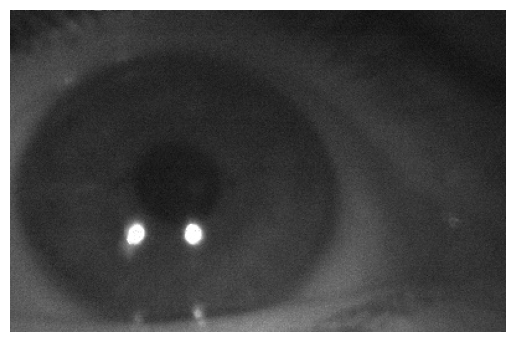

In [6]:
plt.imshow(img, cmap='gray')
plt.axis('off')

In [7]:
arr.shape

(260, 400, 1)

In [8]:
ds_train = image_dataset_from_directory(DATA_DIR,
                                        labels='inferred',
                                        validation_split=.2,
                                        subset='training',
                                        seed=42,
                                        color_mode='grayscale',
                                        batch_size=32,
                                        image_size=(260, 400))

ds_val = image_dataset_from_directory(DATA_DIR,
                                      labels='inferred',
                                      validation_split=.2,
                                      subset='validation',
                                      seed=42,
                                      color_mode='grayscale',
                                      batch_size=32,
                                      image_size=(260, 400))

Found 826 files belonging to 2 classes.
Using 661 files for training.
Found 826 files belonging to 2 classes.
Using 165 files for validation.


In [9]:
ds_train.class_names

['close', 'open']

2024-09-01 00:11:00.929181: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


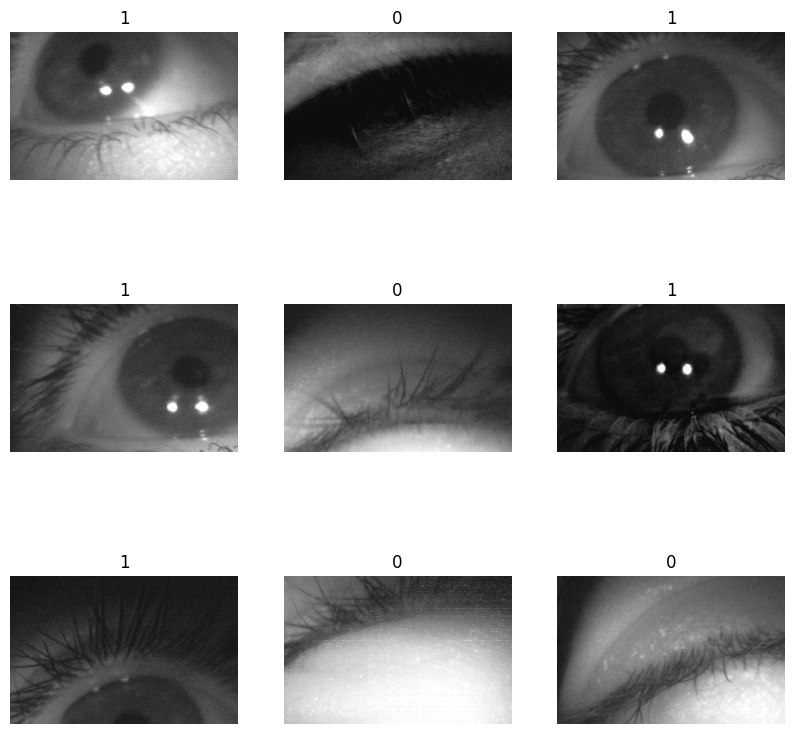

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy() / 255, cmap='Greys_r')
        plt.title(labels.numpy()[i])
        plt.axis("off")

In [11]:
for img, lable in ds_train.take(1):
    print(img.shape[1:])

(260, 400, 1)


2024-09-01 00:11:01.346244: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
input_shape = (260, 400, 1)

def model(input_shape=input_shape, regul=0, drop_rate=0):

    model = Sequential([
        
        Input(shape=input_shape),
        Flatten(),
        Rescaling(1./255),
        
        Dense(32, activation='relu', kernel_regularizer=l2(regul)),
        Dense(32, activation='relu', kernel_regularizer=l2(regul)),
        Dropout(drop_rate),
        Dense(16, activation='relu', kernel_regularizer=l2(regul)),
        Dropout(drop_rate),
        Dense(16, activation='relu', kernel_regularizer=l2(regul)),
        
        Dense(1, activation='sigmoid', kernel_regularizer=l2(regul))
    ])
    
    return model

In [13]:
def compile_model(model, lr=1e-3):
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
    return model

In [14]:
os.makedirs('checkpoint', exist_ok=True)
os.makedirs('tb_logs', exist_ok=True)
path_to_checkpoint = "./checkpoint"

In [15]:
def callbacks(patience=5):
    
    def scheduler(epoch, lr):
        if epoch >= 10:
            if epoch % 10:
                return lr
            else:
                return lr * np.exp(-0.1)
        return lr
    
    lrs = LearningRateScheduler(scheduler)
    
    mc = ModelCheckpoint(path_to_checkpoint+'/.weights.h5', monitor='val_loss', save_weights_only=True, save_best_only=True)
    
    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    tb = TensorBoard(log_dir='./tb_logs', histogram_freq=20)
    
    return [es, lrs, mc, tb]

In [16]:
model = model()
model = compile_model(model)
cb = callbacks()

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 104000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 104000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     3,328,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329,905 (12.70 MB)

 Trainable params: 3,329,905 (12.70 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
ds_train = ds_train.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [19]:
tf.config.run_functions_eagerly(False) # Graph execution, not Eager Execution
model.fit(ds_train,
        validation_data=ds_val,
        epochs=200,
        callbacks=cb)

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5070 - loss: 2.0838 - precision: 0.5879 - recall: 0.4807 - val_accuracy: 0.5818 - val_loss: 1.2840 - val_precision: 0.5818 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5950 - loss: 0.8013 - precision: 0.6601 - recall: 0.6348 - val_accuracy: 0.5576 - val_loss: 0.6853 - val_precision: 0.5714 - val_recall: 0.9583 - learning_rate: 0.0010
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7210 - loss: 0.5705 - precision: 0.7576 - recall: 0.7753 - val_accuracy: 0.5576 - val_loss: 0.6229 - val_precision: 0.5723 - val_recall: 0.9479 - learning_rate: 0.0010
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7387 - loss: 0.5344 - precision: 0.7579 - recall: 0.8326 - val_accuracy: 0.7152 - val_loss: 0.5606 - val_precision: 0.7025 - val_recall: 0.8854 - learning_rate: 0.0010
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 

In [20]:
model.evaluate(ds_val)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9451 - loss: 0.1039 - precision: 0.9651 - recall: 0.9351 


[0.1224750503897667, 0.939393937587738, 0.957446813583374, 0.9375]

In [21]:
for img, l in ds_val.take(1):
    print(img.shape)

(32, 260, 400, 1)


In [22]:
model.predict(ds_val.take(1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


array([[2.38610413e-02],
       [2.30580792e-02],
       [2.14228272e-01],
       [9.17593718e-01],
       [9.99742746e-01],
       [1.08689167e-01],
       [9.99992073e-01],
       [9.99991000e-01],
       [3.53657156e-02],
       [9.85727310e-01],
       [9.94352520e-01],
       [9.98145521e-01],
       [9.99999344e-01],
       [7.17961136e-03],
       [2.60242989e-04],
       [9.99126613e-01],
       [9.99793828e-01],
       [9.70410705e-02],
       [1.27568869e-02],
       [5.20728203e-03],
       [9.99879301e-01],
       [9.93927419e-01],
       [2.38217637e-01],
       [9.97556448e-01],
       [9.99988139e-01],
       [1.89673342e-02],
       [9.96286213e-01],
       [1.00000000e+00],
       [1.17301054e-01],
       [1.30685630e-05],
       [3.12971212e-02],
       [4.40222949e-01]], dtype=float32)

These are the corresponding prediction probabilities for having an open eye for a batch of 32.

## 2. Predict center of an eye using regression

In [23]:
os.listdir(DATA_DIR + '/open/train/')

['openedEye416.jpg',
 'openedEye370.jpg',
 'openedEye364.jpg',
 'openedEye402.jpg',
 'openedEye358.jpg',
 'openedEye172.jpg',
 'openedEye83.jpg',
 'openedEye97.jpg',
 'openedEye166.jpg',
 'openedEye40.jpg',
 'openedEye54.jpg',
 'openedEye68.jpg',
 'openedEye199.jpg',
 'openedEye204.jpg',
 'openedEye210.jpg',
 'openedEye238.jpg',
 'openedEye239.jpg',
 'openedEye211.jpg',
 'openedEye205.jpg',
 'openedEye198.jpg',
 'openedEye69.jpg',
 'openedEye55.jpg',
 'openedEye41.jpg',
 'openedEye167.jpg',
 'openedEye96.jpg',
 'openedEye82.jpg',
 'openedEye173.jpg',
 'openedEye359.jpg',
 'openedEye365.jpg',
 'openedEye403.jpg',
 'openedEye417.jpg',
 'openedEye371.jpg',
 'openedEye401.jpg',
 'openedEye367.jpg',
 'openedEye373.jpg',
 'openedEye415.jpg',
 'openedEye429.jpg',
 'openedEye398.jpg',
 'openedEye94.jpg',
 'openedEye165.jpg',
 'openedEye171.jpg',
 'openedEye80.jpg',
 'openedEye159.jpg',
 'openedEye57.jpg',
 'openedEye43.jpg',
 'openedEye213.jpg',
 'openedEye207.jpg',
 'openedEye206.jpg',
 'open

In [24]:
df = pd.read_csv(DATA_DIR + '/open/train/dataPupilCenterTrain.csv')
df

,id,xcentral,ycentral
0,0,220,90
1,1,235,102
2,2,221,138
3,3,307,84
4,4,295,80
...,...,...,...
475,475,353,178
476,476,351,154
477,477,351,133
478,478,350,118


In [25]:
df = df.drop(df[(df['xcentral'] == '?') | (df['ycentral'] == '?')].index, axis=0)
src = DATA_DIR+"open/train/openedEye" + df['id'].astype(str) + ".jpg" + "," + df['xcentral'] + "," + df['ycentral']

In [26]:
src

0         ./src/open/train/openedEye0.jpg,220,90
1        ./src/open/train/openedEye1.jpg,235,102
2        ./src/open/train/openedEye2.jpg,221,138
3         ./src/open/train/openedEye3.jpg,307,84
4         ./src/open/train/openedEye4.jpg,295,80
                         ...                    
475    ./src/open/train/openedEye475.jpg,353,178
476    ./src/open/train/openedEye476.jpg,351,154
477    ./src/open/train/openedEye477.jpg,351,133
478    ./src/open/train/openedEye478.jpg,350,118
479    ./src/open/train/openedEye479.jpg,343,102
Length: 431, dtype: object

In [27]:
ds = Dataset.from_tensor_slices(src[:400])
ds

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [28]:
def get_target(sample):
    return strings.to_number(strings.split(sample, ',')[1:])

def get_image(sample):
    file_path = strings.split(sample, ',')[0]
    file = read_file(file_path)
    img = decode_image(file, channels=1)
    return img

def process_sample(sample):
    image = get_image(sample)
    image = tf.image.resize_with_pad(image, target_width=300, target_height=300)
    target = get_target(sample)
    return image, target

In [29]:
print(tf.executing_eagerly())

True


In [39]:
ds_mapped = ds.map(process_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_mapped = ds_mapped.batch(100).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

/Users/ismailsmac/code/Ismail-ai707/student-challenges/myenv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [40]:
for img, label in ds_mapped.take(1):
    print("Image shape:", img.shape)
    print("Label:", label)

Image shape: (100, 300, 300, 1)
Label: tf.Tensor(
[[220.  90.]
 [235. 102.]
 [221. 138.]
 [307.  84.]
 [295.  80.]
 [259.  87.]
 [242. 107.]
 [245. 129.]
 [279. 148.]
 [309. 151.]
 [350. 155.]
 [367. 147.]
 [371. 141.]
 [217. 132.]
 [374. 141.]
 [372. 133.]
 [372. 133.]
 [368. 131.]
 [370. 133.]
 [240. 120.]
 [227. 118.]
 [205. 127.]
 [188. 135.]
 [180. 139.]
 [221. 129.]
 [187. 140.]
 [186. 136.]
 [188. 138.]
 [191. 136.]
 [182. 125.]
 [180. 124.]
 [161. 125.]
 [139. 132.]
 [150. 149.]
 [185. 169.]
 [216. 130.]
 [243. 179.]
 [284. 166.]
 [308. 156.]
 [321. 139.]
 [316. 111.]
 [297.  89.]
 [260.  75.]
 [193.  77.]
 [161.  89.]
 [142. 100.]
 [123. 126.]
 [138. 119.]
 [142. 129.]
 [157. 142.]
 [191. 158.]
 [232. 166.]
 [247. 163.]
 [260. 152.]
 [264. 145.]
 [268. 154.]
 [264. 152.]
 [120. 126.]
 [266. 154.]
 [266. 151.]
 [265. 154.]
 [261. 152.]
 [254. 147.]
 [246. 148.]
 [243. 147.]
 [225. 192.]
 [228. 198.]
 [206. 197.]
 [118. 125.]
 [204. 199.]
 [206. 196.]
 [211. 186.]
 [193. 180.]
 

2024-09-01 00:12:08.501953: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [41]:
def nn_model(input_dim, regul=0.02):

    model = Sequential([
        Input(shape=input_dim),
        Flatten(),
        Rescaling(1./255),
        Dense(32, activation='relu', kernel_regularizer=l2(regul)),
        Dense(32, activation='relu', kernel_regularizer=l2(regul)),
        Dense(16, activation='relu', kernel_regularizer=l2(regul)),
        Dense(16, activation='relu', kernel_regularizer=l2(regul)),
        Dense(2, activation='linear', kernel_regularizer=l2(regul))
    ])
    return model

In [42]:
model = nn_model(input_dim=(300, 300, 1),regul=0.02)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 90000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 90000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │     2,880,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881,922 (10.99 MB)

 Trainable params: 2,881,922 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Define now our callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

# Finally fit the model
tf.config.run_functions_eagerly(True)
model.fit(ds_mapped, epochs=100, callbacks=callbacks)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 37072.9375
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 31047.1309
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 23284.3633
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 15057.2451
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 8931.9814
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 7607.9995
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 8120.3506
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 7001.4600
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6376.6602
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6760.1626
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7034.6196
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6795.8784
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6371.9673
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 6082.4712
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0

In [44]:
model.predict(ds_mapped)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([[210.50671 ,  76.86855 ],
       [236.99126 , 107.49436 ],
       [246.68481 , 169.21135 ],
       [254.29019 ,  88.079475],
       [231.7497  ,  86.133224],
       [206.30096 ,  78.95421 ],
       [213.2564  , 110.1823  ],
       [239.03352 , 119.995674],
       [270.60287 , 151.20865 ],
       [285.72302 , 158.9801  ],
       [308.88852 , 163.692   ],
       [314.00818 , 158.19025 ],
       [317.16156 , 151.057   ],
       [242.79436 , 161.50922 ],
       [315.7466  , 149.90027 ],
       [315.99683 , 147.0544  ],
       [313.03162 , 141.89195 ],
       [315.39493 , 143.2894  ],
       [316.9052  , 144.5061  ],
       [107.34293 ,  67.803444],
       [101.92117 ,  65.867096],
       [ 93.206245,  67.09917 ],
       [ 88.75219 ,  74.917076],
       [ 82.528435,  74.92395 ],
       [238.46904 , 152.14282 ],
       [ 86.71896 ,  76.4556  ],
       [169.39055 , 131.67712 ],
       [195.96472 , 153.83125 ],
       [207.05331 , 162.8854  ],
       [209.14415 , 145.30452 ],
       [19

These are the predicted (x,y) coordinates for eyes centers.

In [45]:
X_test = src[400:]
X_test = Dataset.from_tensor_slices(X_test)
X_test = X_test.map(process_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
X_test = X_test.batch(16).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [46]:
for img, label in X_test.take(1):
    print(img.shape)

(16, 300, 300, 1)


2024-09-01 00:12:40.910488: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [47]:
y_pred_test = model.predict(X_test, verbose=0)
y_pred_test

array([[161.03543 , 166.52829 ],
       [158.396   , 165.05605 ],
       [153.73225 , 160.92699 ],
       [228.44283 , 123.81278 ],
       [278.16574 , 165.04456 ],
       [274.71652 , 148.40576 ],
       [279.11102 , 153.35999 ],
       [280.30988 , 149.50276 ],
       [274.0433  , 148.73413 ],
       [264.583   , 142.588   ],
       [251.24376 , 133.30853 ],
       [234.8168  , 128.53535 ],
       [214.7546  , 121.26316 ],
       [212.34113 , 123.437996],
       [214.86868 , 117.032906],
       [265.39987 , 171.0375  ],
       [239.2279  , 119.8573  ],
       [275.67056 , 133.28246 ],
       [290.07205 , 126.55988 ],
       [307.0638  , 148.61317 ],
       [252.23488 , 171.92612 ],
       [292.26407 , 151.57495 ],
       [290.7408  , 180.2719  ],
       [331.32077 , 221.9031  ],
       [357.8671  , 245.75711 ],
       [334.23822 , 226.35832 ],
       [303.40015 , 187.07634 ],
       [293.6798  , 155.93791 ],
       [299.681   , 151.39943 ],
       [299.10162 , 132.89519 ],
       [27

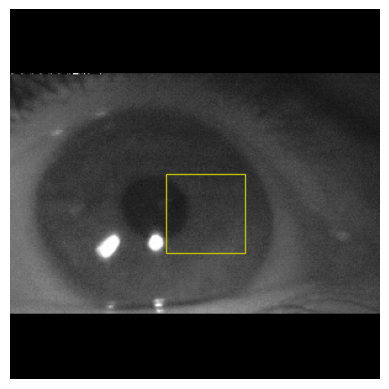

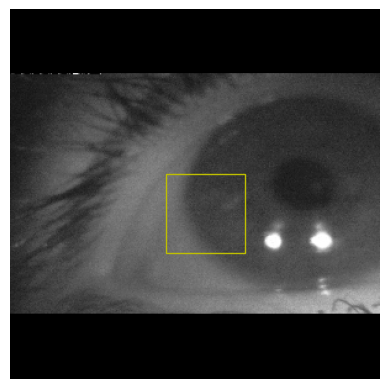

In [50]:
# Display the results for some eyes
import matplotlib.patches as patches

# Get a batch of images and their true labels
for images, labels in X_test.take(2):  # Take one batch
    
    index = 1  # Adjust this if needed, but ensure it's less than the batch size

    # Image to display
    display = images[index].numpy().squeeze()  # Remove the channel dimension
    box = y_pred_test[index]

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(display, cmap='Greys_r')

    # Create a Rectangle patch
    rect = patches.Rectangle((box[0]-32, box[1]-32), 64, 64, linewidth=1, edgecolor='y', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.axis('off')
    plt.show()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir Graph

#### Have a look at the weights

In [ ]:
path_to_weights = "./checkpoint/.weights.h5"
model.load_weights(path_to_weights)